### TP 1 : General Observation on Order Book Data

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [76]:
# Step 0 : Download of libraries
## allowed libs :  numpy, scipy, pandas, matplotlib, powerlaw, statsmodels,
## tqdm, Hawkes.

import numpy 
import scipy
import pandas as pd 
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
import tqdm   
import Hawkes as hwk

Question 1 : General sanity check and statistical analysis on the dataset

In [77]:
# Step 1: Load all files in the directory
data_path = "Data/SG/"
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
# Create a list to store each DataFrame
df_list = []
for file in file_list:
    df = pd.read_csv(data_path + file, compression='gzip')
    df.drop(df.columns[0], axis=1, inplace=True)
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    df_list.append(df)

# Concatenate all DataFrames into one
filename_df = pd.concat(df_list, ignore_index=True)

# Step 2 : General statistical analysis on the dataset
# 2.1. Check the structure of the data
filename_df.head(50)

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445
5,2017-01-17 09:01:01.110784,C,46005,361,B,46010,1066,46085,1445
6,2017-01-17 09:01:01.140595,A,46010,361,B,46010,1427,46085,1445
7,2017-01-17 09:01:01.142726,M,45905,0,B,46010,1427,46085,1445
8,2017-01-17 09:01:01.143053,C,45960,200,B,46010,1427,46085,1445
9,2017-01-17 09:01:01.143387,C,45965,200,B,46010,1427,46085,1445


In [78]:
# 2.2. Check for missing values
print("DataFrame Info:")
print(filename_df.info())

print("\nMissing values per column:")
print(filename_df.isnull().sum())

# 2.3. Descriptive statistics
print("\nDescriptive Statistics:")
print(filename_df.describe())

# 2.4. Check for duplicates (optional)
duplicates = filename_df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicates}")


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7827010 entries, 0 to 7827009
Data columns (total 9 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ets     datetime64[ns]
 1   etype   object        
 2   eprice  int64         
 3   eqty    int64         
 4   eside   object        
 5   bp0     int64         
 6   bq0     int64         
 7   ap0     int64         
 8   aq0     int64         
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 537.4+ MB
None

Missing values per column:
ets       0
etype     0
eprice    0
eqty      0
eside     0
bp0       0
bq0       0
ap0       0
aq0       0
dtype: int64

Descriptive Statistics:
                                 ets        eprice          eqty  \
count                        7827010  7.827010e+06  7.827010e+06   
mean   2017-01-24 22:36:25.109865984  4.630138e+04  2.330215e+02   
min       2017-01-17 09:01:00.270164  4.600000e+03 -2.217800e+04   
25%    2017-01-19 16:16:42.942011136  4.56

The dataset shows a full day’s worth of trading events with no missing or duplicate rows, which is excellent for high-frequency analysis. Prices range from about 40 000 to 60 760, and best bid/ask prices behave as expected. The only notable anomaly is negative eqty, which indicate cancellations. Otherwise, the data appears reasonably clean and well-structured for deeper market microstructure studies.

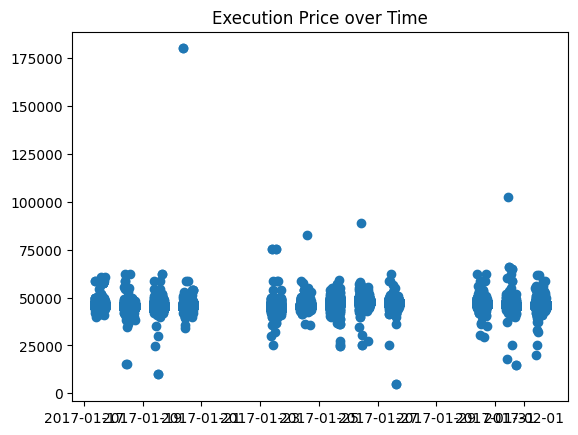

In [79]:
# We are first going to plot the exec price over time
plt.scatter(filename_df['ets'], filename_df['eprice'], marker='o')
plt.title("Execution Price over Time")
plt.show()

In [84]:
## adding for Question 2

filename_df['mid_price'] = (filename_df['bp0'] + filename_df['ap0']) / 2
filename_df['weighted_mid_price'] = (
    filename_df['bp0'] * filename_df['bq0'] + filename_df['ap0'] * filename_df['aq0']
) / (filename_df['bq0'] + filename_df['aq0'])

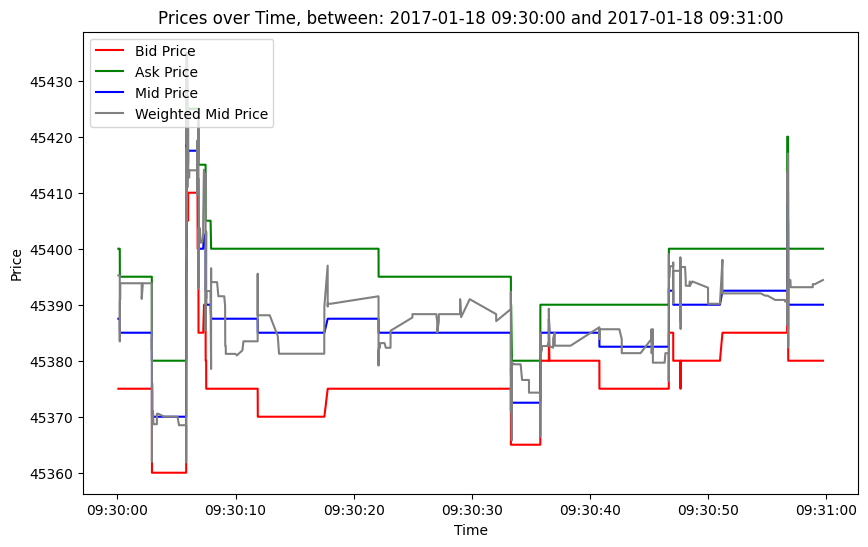

In [91]:
# question 2 : Plot the best bid and ask prices over time, and mid price

#### params ####
start_time = pd.Timestamp("2017-01-18 09:30:00")
end_time = pd.Timestamp("2017-01-18 09:31:00")
################

subset_df = filename_df[(filename_df['ets'] >= start_time) & (filename_df['ets'] <= end_time)]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(subset_df['ets'], subset_df['bp0'], color = "r", label="Bid Price")
ax1.plot(subset_df['ets'], subset_df['ap0'], color = "g", label="Ask Price")
ax1.plot(subset_df['ets'], subset_df['mid_price'], color = "b", label="Mid Price")
ax1.plot(subset_df['ets'], subset_df['weighted_mid_price'], color = "gray", 
         label="Weighted Mid Price")

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
#ax2 = ax1.twinx()
#ax2.plot(subset_df['ets'], subset_df['bq0'], color = "pink", label="Bid "
#                                                                    "Quantity")
#ax2.plot(subset_df['ets'], subset_df['bq0'], color = "lightgreen", 
#         label="Ask "
#                                                                    "Quantity")
#ax2.set_ylabel("Quantity")
ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')
plt.title("Prices over Time, between: " + str(start_time) + " and " +
          str(end_time))
plt.show()

Comments : The plot shows the best bid and ask prices over time, along with the mid price and the weighted mid price. The mid price is the average of the best bid and ask prices, while the weighted mid price is the average of the best bid and ask prices weighted by their respective quantities. The plot shows that the mid price and the weighted mid price are very close, as expected, and that the bid and ask prices are also very close to each other. The plot also shows that the bid and ask prices are very volatile, with frequent changes in direction, while the mid price and the weighted mid price are smoother and more stable. This is because the bid and ask prices are determined by the market participants, while the mid price and the weighted mid price are determined by the market as a whole. The plot also shows that the bid and ask prices are very close to each other, which indicates that the market is very liquid, with a small spread between the bid and ask prices.